In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

ModuleNotFoundError: No module named 'torch'

## - Import

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

NameError: name 'torch' is not defined

## - Parameters

In [4]:
# Data
train_data_path = './FashionMnist/mario_test.csv' # Path of data
valid_data_path = './FashionMnist/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 14 # Image size
batch_size = 32  # Batch size

# Model
z_size = 9
base = 14
# generator_layer_size = [base, base*2, base*4]
# discriminator_layer_size = [base*4, base*2, base]
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 300  # Train epochs
Discriminatorlearning_rate = 1e-4
Generatorlearning_rate = 1e-8

# Save parameters
SaveEachEpochs = 50
SaveModelName = "TestSagan2"
ShouldLoadModel = False

# Show
# ShowSampleEachEpochs = 10
ShowSampleEachEpochs = SaveEachEpochs

# DATA
in_channels = 512

Train data path: ./FashionMnist/mario_test.csv
Valid data path: ./FashionMnist/fashion-mnist_test.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [6]:
class_list = ['Normal', 'Subterraneo', 'Hills']
class_num = len(class_list)

In [7]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        print(self.images.shape)
        self.images = np.stack([self.images]*3, axis =-1)
        print(self.images.shape)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [8]:
dataset = FashionMNIST(train_data_path, img_size)

(2698, 14, 14)
(2698, 14, 14, 3)
Image size: (2698, 14, 14, 3)
--- Label ---
label
0    1829
2     554
1     315
Name: count, dtype: int64


In [9]:
dataset[1][0]

In [10]:
#class_list[dataset[1][1]]

In [11]:
dataset[2][0]

In [12]:
#class_list[dataset[0][1]]

In [13]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [14]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

(2698, 14, 14)
(2698, 14, 14, 3)
Image size: (2698, 14, 14, 3)
--- Label ---
label
0    1829
2     554
1     315
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


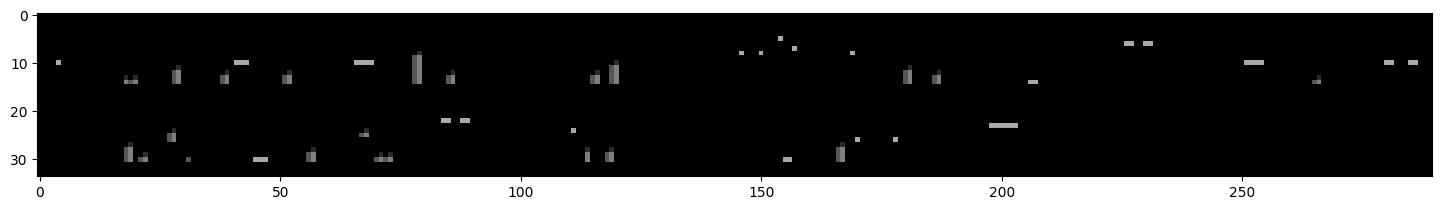

In [15]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,3))
    ax.imshow(make_grid(images, nrow=18).permute(1,2,0))
    break

In [16]:
## SAGAN MODULE
class GeneratorSNBlock(nn.Module):
    # A generator block to upsample the input by a factor of 2
    def __init__(self, in_channels, out_channels):
        super(GeneratorSNBlock, self).__init__()
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        self.conv_module = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.residual_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))

    def forward(self, x):
        identity = x

        # Upsample and SN Conv
        x = self.upsample(x)
        x = self.conv_module(x)

        # Residual connection
        return x + self.residual_conv(self.upsample(identity))


## - Generator

In [17]:
in_channels = 14
z_dim = 14 # its image size?
n_heads = 1
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        print("GENERATOR")
        print(generator_layer_size, z_size, img_size, class_num)
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.z_linear = spectral_norm(
            nn.Linear(z_size, 4 * 4 * in_channels, bias=False)
        )

        self.block1 = GeneratorSNBlock(in_channels, 256)  # 8 x 8
        self.block2 = GeneratorSNBlock(256, 128)  # 16 x 16
        self.block3 = GeneratorSNBlock(128, 64)  # 32 x 32
        self.block4 = GeneratorSNBlock(64, 32)  # 64 x 64
        self.block5 = GeneratorSNBlock(32, 16)  # 128 x 128

        self.attn1 = nn.MultiheadAttention(64, num_heads=n_heads)
        self.alpha = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.last = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, 1, padding=1),
        )


    
    def forward(self, z, labels):
        # # Reshape z
        # # z = z.view(-1, self.z_size)
        # z = self.z_linear(z)
        # z = z.view(-1, self.img_size, 4, 4)
        # z = self.block1(z)
        # z = self.block2(z)
        # z = self.block3(z)
        # z = self.block4(z)
        # z = self.block5(z)
        
        # # One-hot vector to embedding vector
        # c = self.label_emb(labels)

        # print(z.shape)
        # print(c.shape)
        # c = c.unsqueeze(2).unsqueeze(3).expand(-1, -1, z.size(2), z.size(3))
        # # Concat image & label
        # x = torch.cat([z, c.unsqueeze(2).unsqueeze(3).expand(-1, -1, z.size(2), z.size(3))], 1)
        
        # # Generator out
        # out = self.model(x)
        # return out.view(-1, self.img_size, self.img_size)
        ################## SAGAN ##################
        z = self.z_linear(z)
        z = z.view(z.size(0), in_channels, 4, 4)

        # Forward
        out = self.block1(z)
        out = self.block2(out)
        out = self.block3(out)

        #### Attention 1 ####
        identity = out
        B, C, H, W = out.shape
        q_1 = out.view(H * W, B, C)
        k_1 = out.view(H * W, B, C)
        v_1 = out.view(H * W, B, C)
        out, attn_map_1 = self.attn1(q_1, k_1, v_1)
        out = out.view(B, C, H, W)

        # Residual connection
        out = identity + self.alpha * out

        # Forward (contd.)
        out = self.block4(out)
        out = self.block5(out)
        out = self.last(out)

        return torch.tanh(out), attn_map_1

## - Discriminator

In [18]:
class DiscriminatorSNBlock(nn.Module):
    # A generator block to upsample the input by a factor of 2
    def __init__(self, in_channels, out_channels):
        super(DiscriminatorSNBlock, self).__init__()
        self.relu = nn.ReLU()
        self.downsample = nn.AvgPool2d(2)

        self.conv_module = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)),
            nn.ReLU(),
        )

        self.residual_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))

    def forward(self, x):
        identity = x

        # SN Conv and Downsample
        x = self.conv_module(x)
        x = self.downsample(x)

        # Residual connection
        return x + self.residual_conv(self.downsample(identity))

In [20]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        # self.img_size = img_size
        
        # self.model = nn.Sequential(
        #     nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Dropout(0.3),
        #     nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Dropout(0.3),
        #     nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Dropout(0.3),
        #     nn.Linear(discriminator_layer_size[2], 1),
        #     nn.Sigmoid()
        # )
        self.n_heads = n_heads

        self.block0 = DiscriminatorSNBlock(3, 32)  # 64 x 64
        self.block1 = DiscriminatorSNBlock(32, 64)  # 32 x 32
        self.block2 = DiscriminatorSNBlock(64, 128)  # 16 x 16
        self.block3 = DiscriminatorSNBlock(128, 256)  # 8 x 8
        self.block4 = DiscriminatorSNBlock(256, 512)  # 4 x 4

        self.flatten = nn.Flatten()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.clf = nn.Linear(256, 1, bias=False)

        self.attn1 = nn.MultiheadAttention(64, num_heads=self.n_heads)
        self.alpha = nn.Parameter(torch.tensor(0.0), requires_grad=True)
    
    def forward(self, x, labels):
        
        # # Reshape fake image
        # x = x.view(-1, self.img_size * self.img_size)
        
        # # One-hot vector to embedding vector
        # c = self.label_emb(labels)
        
        # # Concat image & label
        # x = torch.cat([x, c], 1)
        
        # # Discriminator out
        # out = self.model(x)
        
        # return out.squeeze()
        
        # Forward
        out = self.block0(x)
        out = self.block1(out)

        #### Attention 1 ####
        identity = out
        B, C, H, W = out.shape
        q_1 = out.view(H * W, B, C)
        k_1 = out.view(H * W, B, C)
        v_1 = out.view(H * W, B, C)
        out, attn_map_1 = self.attn1(q_1, k_1, v_1)
        out = out.view(B, C, H, W)

        # Residual connection
        out = identity + self.alpha * out

        # Forward (contd.)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.avg_pool(out)
        out = self.flatten(out)

        return self.clf(out).squeeze(), attn_map_1

In [21]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

GENERATOR
[256, 512, 1024] 9 14 3


## - Adversarial Learning of Generator & Discriminator

In [19]:
# Loss function
criterion = nn.BCELoss()

In [20]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=Generatorlearning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=Discriminatorlearning_rate)

In [22]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [23]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [23]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(data_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        # print(real_images[0])
        # print("labels")
        # print(labels[0])
        # break
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    # break
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    if((epoch + 1) % SaveEachEpochs == 0):
        torch.save(generator.state_dict(),f'Checkpoints/{SaveModelName}Gen{epoch+1}.pth')
        torch.save(generator.state_dict(),f'Checkpoints/{SaveModelName}Dis{epoch+1}.pth')

    if((epoch + 1) % ShowSampleEachEpochs == 0):
        # Show images
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

Starting epoch 1...


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

## - Show Generating Images

In [25]:
# DAta

mapeo_caracteres = {'X': 0, 'S': 1, '-': 2, '?': 3, 'Q': 4, 'E': 5, '<': 6, '>': 7, '[': 8, ']': 9, 'o': 10, 'B': 11, 'b': 12}
mapeo_caracteres_inverso = {valor: clave for clave, valor in mapeo_caracteres.items()}
map_number = len(mapeo_caracteres.keys())

import torchvision.transforms.functional as TF
def lerp(a, b, t):
    return a * (1 - t) + b * t
def CloserNumber(list,number):
    return min(list, key=lambda x: abs(x - number))
def Decoder(sample_images):
    print("tensor edit")
    
    for i in range(len(sample_images)):
        rows,cols = sample_images[i][0].shape
        for j in range(rows):
            for k in range(cols):
                sample_images[i][0][j][k] = round(CloserNumber(data_normalized,sample_images[i][0][j][k]),8)
def ConverToTxt(sample_images):
    print("tensor edit")
    
    for i in range(len(sample_images)):
        rows,cols = sample_images[i][0].shape
        for j in range(rows):
            for k in range(cols):
                sample_images[i][0][j][k] = round(CloserNumber(data_normalized,sample_images[i][0][j][k]),8)

dataRGBrange = [ i/(map_number-1) * 255 for i in range(map_number)]
data_normalized = [ lerp(0,1,i/(map_number-1)) for i in range(map_number)]
print(dataRGBrange)
print(data_normalized)
def convertir_png_a_txt(ruta_imagen, ruta_txt):
    # Abrir la imagen PNG
    imagen = Image.open(ruta_imagen)

    # Obtener dimensiones de la imagen
    ancho, alto = imagen.size

    # Obtener los píxeles de la imagen
    pixeles = imagen.load()

    # Abrir o crear el archivo de texto para escribir
    with open(ruta_txt, 'w') as archivo_txt:
        # Iterar sobre cada píxel y escribir su valor en el archivo de texto
        for y in range(alto):
            for x in range(ancho):
                # Obtener el valor del píxel en formato RGB (tupla)
                valor_pixel =  mapeo_caracteres_inverso[CloserNumber(dataRGBrange,pixeles[x,y])*(map_number-1)/255]
               
                
                # Convertir la tupla de RGB a cadena y escribir en el archivo de texto
                archivo_txt.write(f"{valor_pixel}")

            # Agregar un salto de línea al final de cada fila
            archivo_txt.write("\n")

# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

    
# Labels 0 ~ 9
testlabels = np.full(z_size, 0)
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)
#labels = Variable(torch.LongTensor(testlabels)).to(device)
print(labels)
# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
# Decoder(sample_images)

## Saving Images
pil_images = [TF.to_pil_image(image) for image in sample_images]
for i, pil_image in enumerate(pil_images):
    pil_image.save(f"imagen_{i}.png")
    convertir_png_a_txt(f"imagen_{i}.png", f"MarioBrosImageRenderer/GeneratedLevels/imagen_{i}.txt")

## Converting images to 
execfile('MarioBrosImageRenderer/gameImageGenerator.py')
# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(8, 6*8, 16), class_list, rotation=45, fontsize=20)

from PIL import Image



[0.0, 21.25, 42.5, 63.75, 85.0, 106.25, 127.5, 148.75, 170.0, 191.25, 212.5, 233.75, 255.0]
[0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5833333333333334, 0.6666666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 1.0]
tensor([0, 1, 2, 0, 1, 2, 0, 1, 2], device='cuda:0')


AttributeError: 'tuple' object has no attribute 'unsqueeze'

In [1]:
fileToLoad = "Checkpoints/Test20000EpochsGen20000.pth"
GeneratorLoader = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
GeneratorLoader.load_state_dict(torch.load(fileToLoad))

z = Variable(torch.randn(z_size, z_size)).to(device)

testlabels = np.full(z_size, 0)
labels = Variable(torch.LongTensor([1 for _ in range(class_num) for i in range(class_num)])).to(device)

sample_images = GeneratorLoader(z, labels).unsqueeze(1).data.cpu()
## Saving Images
pil_images = [TF.to_pil_image(image) for image in sample_images]
for i, pil_image in enumerate(pil_images):
    pil_image.save(f"imagen_{i}.png")
    convertir_png_a_txt(f"imagen_{i}.png", f"MarioBrosImageRenderer/GeneratedLevels/imagen_{i}.txt")



NameError: name 'Generator' is not defined